In [1]:
import sys

if ".." not in sys.path:
    sys.path.append("..") 


from envs.blackjack import BlackjackEnv

In [2]:
import gym
import matplotlib
import numpy as np
from collections import defaultdict

In [3]:
import plotting

In [4]:
env = BlackjackEnv()

In [5]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

def strategy(observation):
    score, dealer_score, usable_ace = observation
    # Stick (action 0) if the score is > 20, hit (action 1) otherwise
    return 0 if score >= 20 else 1

for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        print_observation(observation)
        action = strategy(observation)
        print("Taking action: {}".format( ["Stick", "Hit"][action]))
        observation, reward, done, _ = env.step(action)
        if done:
            print_observation(observation)
            print("Game end. Reward: {}\n".format(float(reward)))
            break

Player Score: 13 (Usable Ace: False), Dealer Score: 8
Taking action: Hit
Player Score: 23 (Usable Ace: False), Dealer Score: 13
Game end. Reward: -1.0

Player Score: 20 (Usable Ace: False), Dealer Score: 6
Taking action: Stick
Player Score: 20 (Usable Ace: False), Dealer Score: 26
Game end. Reward: 1.0

Player Score: 20 (Usable Ace: False), Dealer Score: 10
Taking action: Stick
Player Score: 20 (Usable Ace: False), Dealer Score: 23
Game end. Reward: 1.0

Player Score: 12 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 14 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 17 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 27 (Usable Ace: False), Dealer Score: 19
Game end. Reward: -1.0

Player Score: 14 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 24 (Usable Ace: False), Dealer Score: 16
Game end. Reward: -1.0

Player Score: 14 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score:

In [19]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i in range(num_episodes):
        #print ('Episode ', i)
        # states that has been explored in this episode
        tracked_states = []
        
        observation = env.reset()
        score, dealer_score, usable_ace = observation
        tracked_states.append(score)
        
        done = False
        #print (observation)
        
        while not done:
            action = policy(observation)
            
            observation, reward, done, _ = env.step(action)
            #print (observation)
            score, _, _ = observation
            
            # when score > 21, the game already terminate, so we don't really care
            if score <= 21:
                tracked_states.append(score)
        
        # We just need to use one reward, because reward only != 0 at end game
        for s in tracked_states:
            returns_sum[(s, dealer_score, usable_ace)] += reward 
            returns_count[(s, dealer_score, usable_ace)] += 1
            
    for s in returns_sum:
        # You don't need to check for 0 division
        V[s] = returns_sum[s] / returns_count[s]
    return V

In [15]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

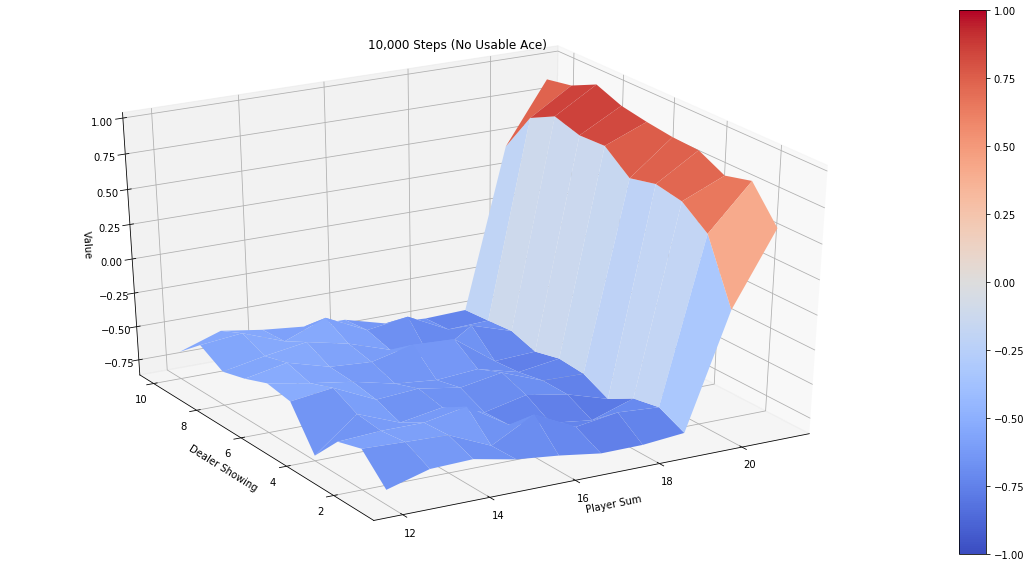

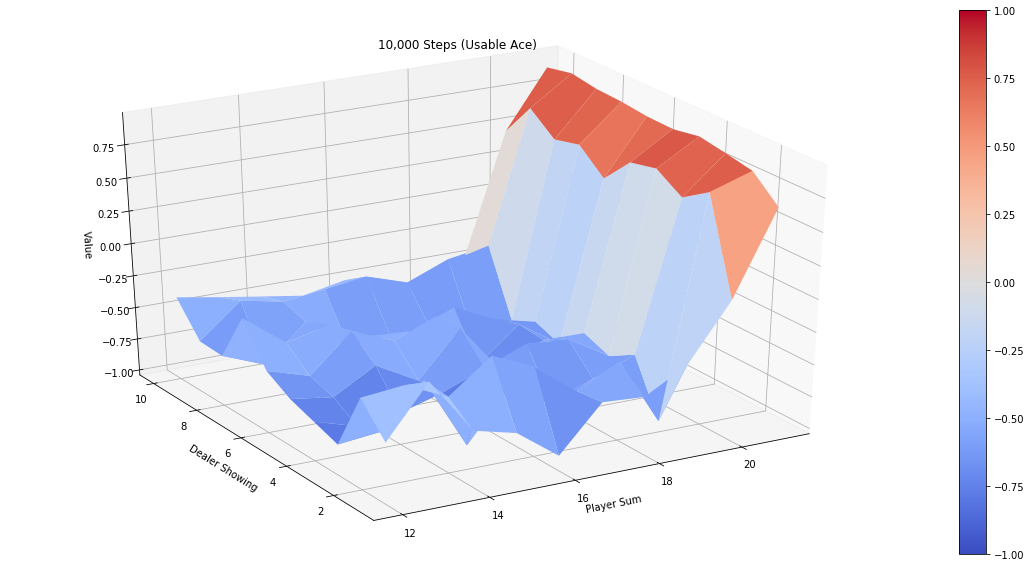

In [23]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

#

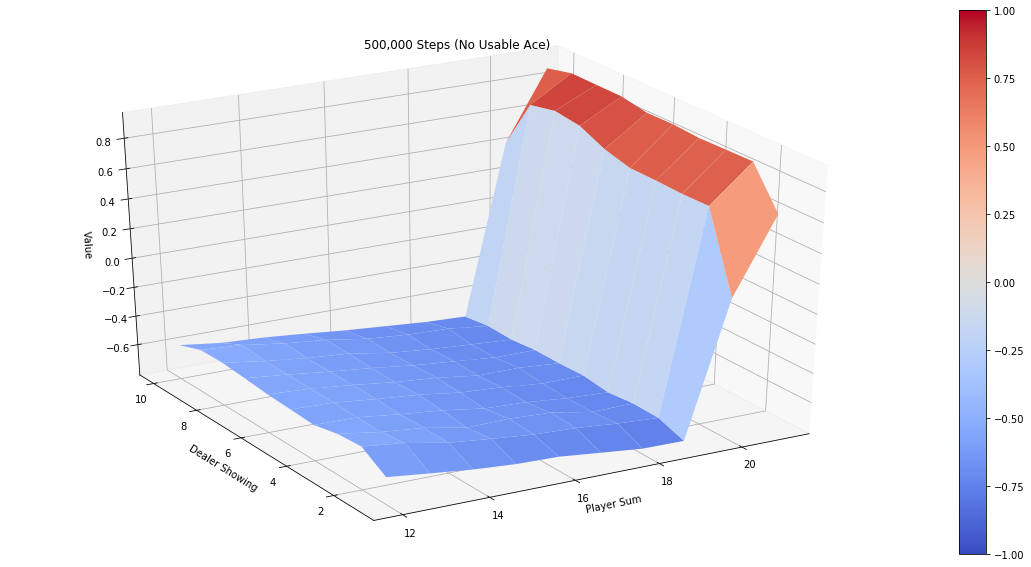

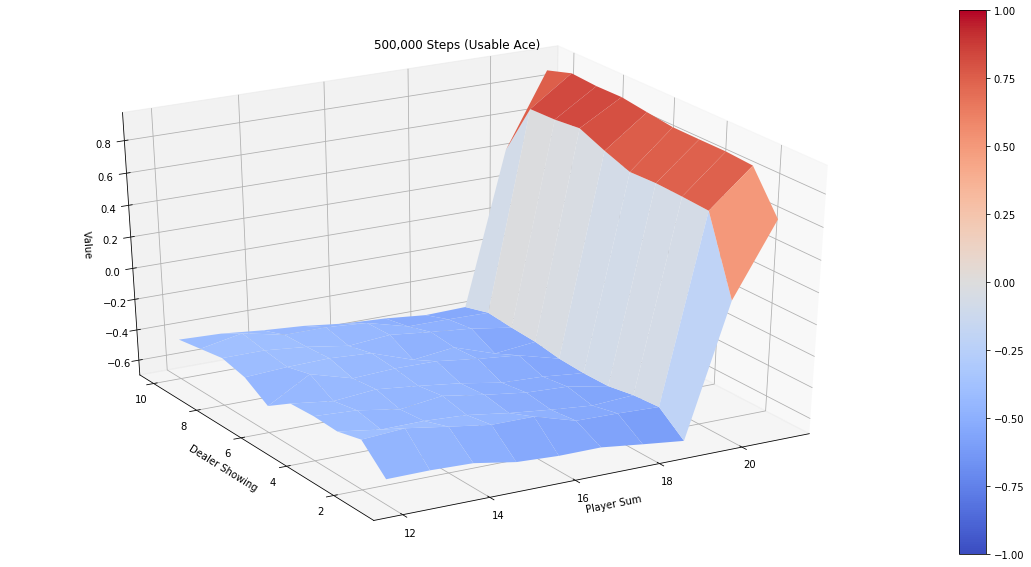

In [24]:
V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")

In [29]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        max_Q_value = -np.inf
        max_action = -1
        
        for action in range(nA):
            if Q[observation][action] > max_Q_value:
                max_Q_value = Q[observation][action]
                max_action = action
        
        probs = np.zeros(nA)
        probs += epsilon / nA
        probs[max_action] += 1 - epsilon
        return probs
        
    return policy_fn

In [34]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i in range(num_episodes):
        tracked_state_actions = []
        
        observation = env.reset()
        score, dealer_score, usable_ace = observation
        
        done = False
        
        while not done:
            action = np.random.choice(env.action_space.n, p = policy(observation))
            tracked_state_actions.append((observation, action))
            
            observation, reward, done, _ = env.step(action)
            
        for state, action in tracked_state_actions:
            returns_sum[(state, action)] += reward
            returns_count[(state, action)] += 1
        
        for state, action in returns_sum:
            Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
    
        # change policy
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    return Q, policy

In [39]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

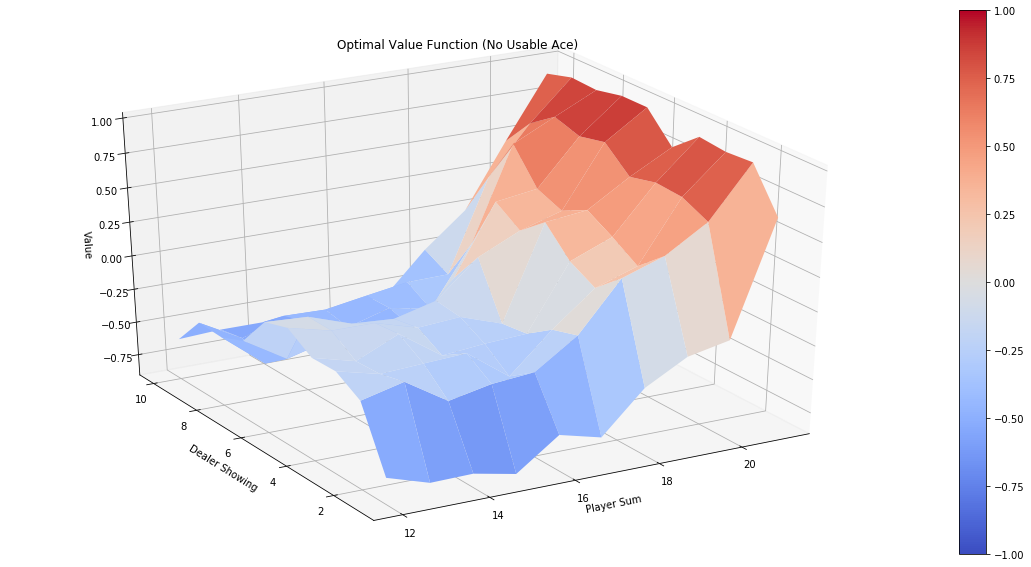

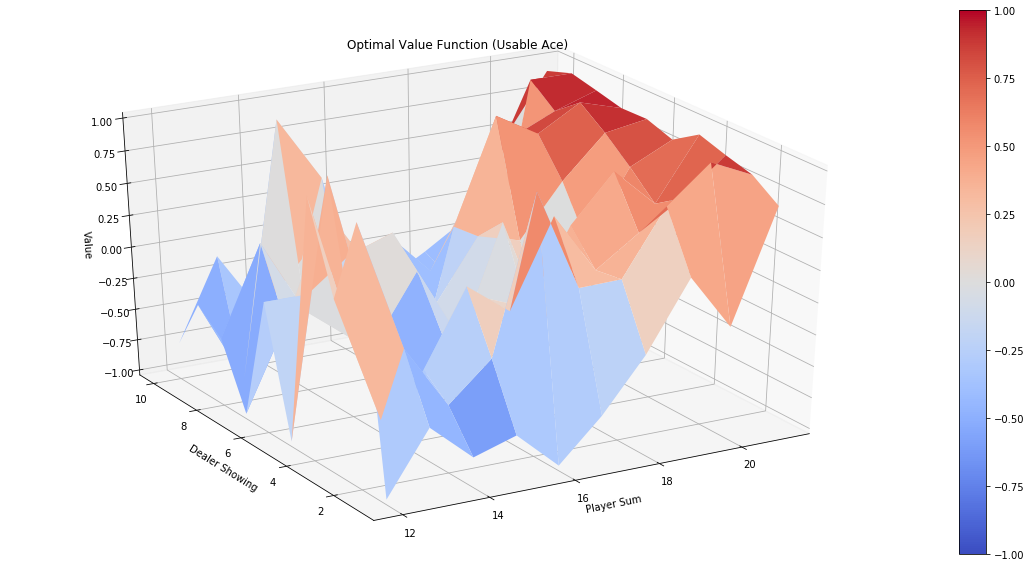

In [40]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [41]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)


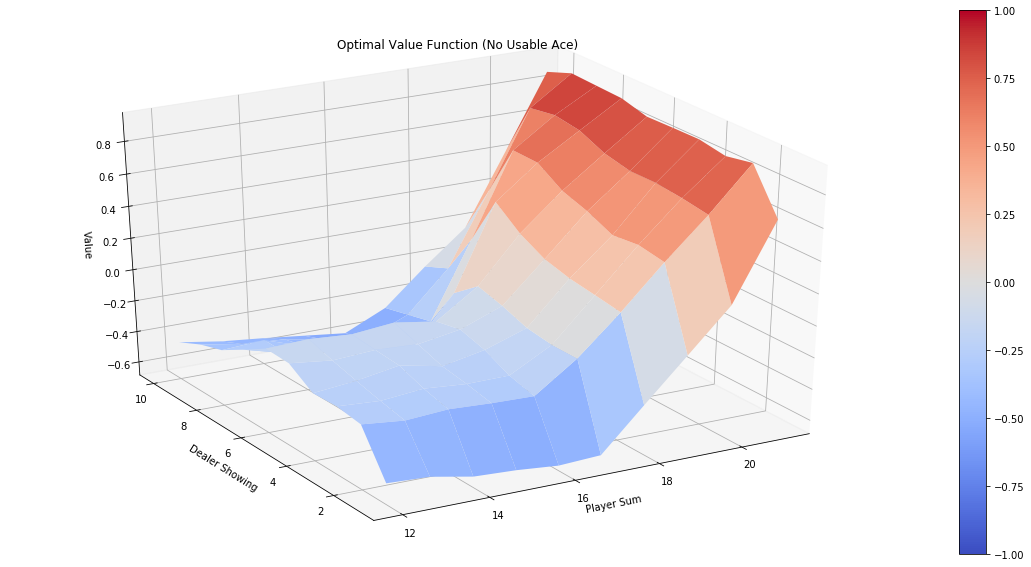

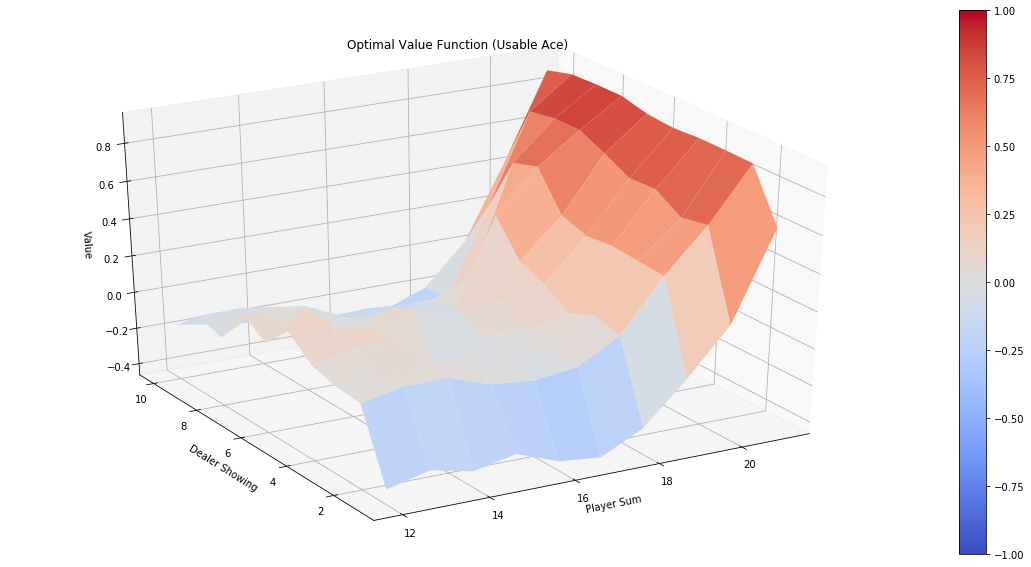

In [42]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [94]:
state = (16,2,False)
print (Q[state])
print (policy(state))

[-0.30106383 -0.58415842]
[ 0.95  0.05]


In [43]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [44]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        max_Q_value = -np.inf
        max_action = -1
        
        for action in range(nA):
            if Q[observation][action] > max_Q_value:
                max_Q_value = Q[observation][action]
                max_action = action
        
        probs = np.zeros(nA)
        probs[max_action] += 1 
        return probs
    return policy_fn

In [45]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # A dictionary that maps state -> action -> weighed count of state action
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Behavior policy 
    behavior_policy = create_random_policy(env.action_space.n)
    
    for i in range(num_episodes):
        tracked_state_actions = []
        
        observation = env.reset()
        score, dealer_score, usable_ace = observation
        
        done = False
        
        while not done:
            action = np.random.choice(env.action_space.n, p = behavior_policy(observation))
            tracked_state_actions.append((observation, action))
            
            observation, reward, done, _ = env.step(action)
            
        W = 1.0
        for t in range(len(tracked_state_actions)-1,0,-1):
            s, a = tracked_state_actions[t]
            C[s][a] += W
            Q[s][a] += W * (reward - Q[s][a]) / C[s][a]
            # Originally, it should be W = W * target / behavior, but 
            # target is greedy, so the denominator is either 0 (break) or 1
            if action != np.argmax(target_policy(state)[action]):
                break
            W /= behavior_policy(state)[action]
        
    return Q, target_policy